# J1 League Scouting Analysis

### Importing Libraries & Dataset

In [1]:
# Importing relevant libraries
import pandas as pd # Data manipulation
import numpy as np # Mathematical functions
import seaborn as sns # Data visualisation
from matplotlib import pyplot # Data visualisation
import matplotlib.pyplot as plt # Data visualisation
from scipy.stats import pearsonr # Pearson's Correlation
from xgboost import XGBRegressor # XGBoost Regressor
from sklearn.metrics import mean_squared_error as MSE # RMSE for model evaluation
from sklearn.model_selection import train_test_split, KFold # sklearn modules
# conda install -c conda-forge xgboost
import xgboost as xgb # XGBoost
# conda install -c conda-forge scikit-optimize
from skopt import BayesSearchCV # Bayesian Optimization
from time import time

In [2]:
# Reading excel file as pandas DataFrame
j1_players = pd.read_excel('Application Task Data.xlsx')
# Removing players who have played less than 90 minutes
j1_players = j1_players[j1_players['Minutes played'] > 90]
# Creating expected goal involvement per 90 column
j1_players['xGI per 90'] = j1_players['xG per 90'] + j1_players['xA per 90']
# Creating successful dribbles per 90 column
j1_players['Successful dribbles per 90'] = j1_players['Dribbles per 90'] * j1_players['Successful dribbles, %']/100
# Creating accurate passes to final 3rd per 90 column
j1_players['Acc. passes to final 3rd per 90'] = j1_players['Passes to final third per 90'] * j1_players['Accurate passes to final third, %']/100
# Creating accurate passes to penalty area per 90 column
j1_players['Acc. passes to penalty area per 90'] = j1_players['Passes to penalty area per 90'] * j1_players['Accurate passes to penalty area, %']/100
# Creating accurate progressive passes per 90 column
j1_players['Acc. progressive passes per 90'] = j1_players['Progressive passes per 90'] * j1_players['Accurate progressive passes, %']/100
# Output
j1_players

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",xGI per 90,Successful dribbles per 90,Acc. passes to final 3rd per 90,Acc. passes to penalty area per 90,Acc. progressive passes per 90
0,J. Świerczok,Nagoya Grampus,Nagoya Grampus,CF,29,2700000,2024-01-31,14,834,7,...,0.32,66.67,0.00,0,0,0.42,1.834340,1.292835,0.969220,2.156608
1,Y. Muto,Vissel Kobe,Vissel Kobe,"CF, RAMF, RCMF",29,2500000,2023-01-31,18,1593,6,...,0.00,0.00,0.00,1,0,0.31,1.862469,1.133271,0.793305,1.921000
2,Lincoln,Vissel Kobe,Vissel Kobe,CF,21,2400000,2024-01-31,18,673,1,...,0.00,0.00,0.00,0,0,0.27,2.004492,2.269500,0.670000,2.138262
3,Diego Pituca,Kashima Antlers,Kashima Antlers,"LCMF, RCMF, RDMF",29,2200000,2024-01-31,30,2486,2,...,0.11,0.00,1.52,0,0,0.17,1.592629,6.513659,1.956050,7.350002
5,Andrés Iniesta,Vissel Kobe,Vissel Kobe,AMF,37,2000000,2024-01-31,29,2042,7,...,0.26,16.67,1.54,4,100,0.38,2.510298,8.328024,2.686202,7.534240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,K. Ishikawa,Gamba Osaka,Gamba Osaka,GK,29,50000,NaN,5,492,0,...,NaN,NaN,0.00,0,0,0.00,0.000000,0.549375,0.000000,4.206573
595,R. Tsunoda,Yokohama F. Marinos,Yokohama F. Marinos,LCB,22,50000,2025-01-31 00:00:00,4,313,0,...,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN
596,Y. Minami,Omiya Ardija,Omiya Ardija,GK,42,25000,NaN,7,681,0,...,NaN,NaN,0.00,0,0,0.00,0.000000,0.926550,0.000000,2.776746
598,H. Hogang,Yokohama,Yokohama,"CB, LCB, RCB",28,0,NaN,24,1974,0,...,0.00,0.00,0.00,0,0,0.04,0.180009,2.141184,0.135000,3.327401


## Identifying Attacking Options (without considering player market value)

### Identifying Strikers

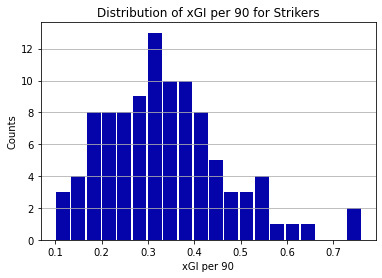

In [3]:
# Subsetting strikers
strikers = j1_players[j1_players['Position'].str.contains('CF')]
# Selecting relevant criteria
strikers = strikers[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90']].dropna()
# Plotting distribution of xGI per 90 for strikers
strikers['xGI per 90'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#0504aa')
# Setting plot titles
plt.title('Distribution of xGI per 90 for Strikers')
# Setting x-axis & y-axis titles
plt.xlabel('xGI per 90')
plt.ylabel('Counts')
# Adding horizontal grid lines to plot
plt.grid(axis='x', alpha=0.75)

In [20]:
# Sorting by xGI
strikers_xGI = strikers.sort_values(by='xGI per 90', ascending=False).head(10)
strikers_xGI.style.background_gradient(subset=['xG per 90', 'xA per 90', 'xGI per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90
6,K. Junker,Urawa Reds,CF,28,2000000,1468,10,1,0.640000,0.120000,0.760000
25,Anderson Lopes,Yokohama F. Marinos,"CF, RWF",28,1200000,1257,9,2,0.680000,0.050000,0.730000
23,Y. Kobayashi,Kawasaki Frontale,"CF, RWF, RW",34,1300000,1179,6,2,0.460000,0.170000,0.630000
26,A. Ueda,Kashima Antlers,CF,23,1200000,2189,17,1,0.540000,0.080000,0.620000
62,Léo Ceará,Yokohama F. Marinos,CF,27,800000,1655,10,5,0.440000,0.150000,0.590000
9,Leandro Damião,Kawasaki Frontale,CF,32,1900000,2493,19,5,0.440000,0.110000,0.550000
175,Douglas Vieira,Sanfrecce Hiroshima,CF,34,500000,1010,5,1,0.410000,0.140000,0.550000
153,K. Chinen,Kawasaki Frontale,CF,27,600000,976,6,0,0.490000,0.050000,0.540000
325,Douglas,Consadole Sapporo,"CF, AMF",27,150000,454,2,0,0.500000,0.030000,0.530000
138,Y. Kamiya,Shimizu S-Pulse,"LW, CF, RW",24,600000,1728,3,7,0.270000,0.250000,0.520000


<AxesSubplot:>

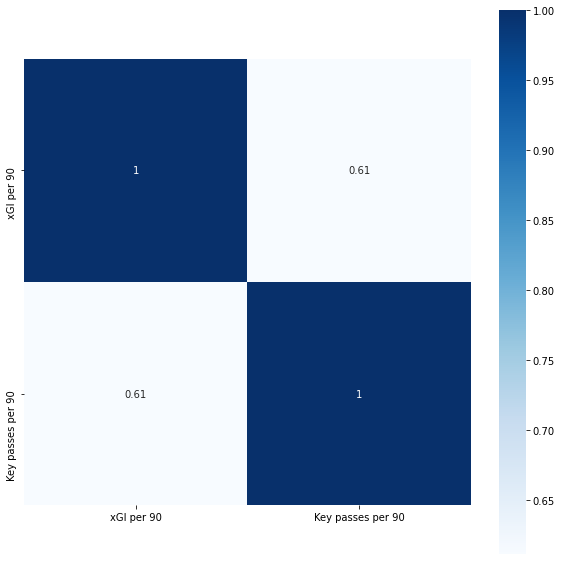

In [5]:
corr_xGI_keypass = j1_players[['xGI per 90', 'Key passes per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_xGI_keypass.corr(), square=True, annot=True, cmap="Blues")

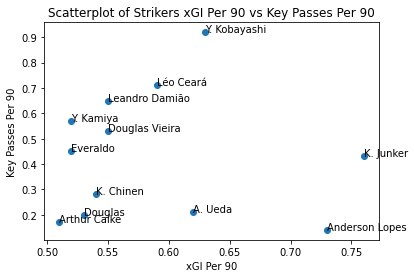

In [6]:
# Subsetting strikers with xGI greater than 0.5
strikers_scatter = j1_players[j1_players['Position'].str.contains('CF')]
strikers_scatter = strikers_scatter[strikers_scatter['xGI per 90'] > 0.5]
# Selecting relevant criteria
strikers_scatter = strikers_scatter[['Player', 'xGI per 90', 'Key passes per 90']].dropna()

# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = strikers_scatter['xGI per 90'], y = strikers_scatter['Key passes per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Strikers xGI Per 90 vs Key Passes Per 90')
ax.set_xlabel('xGI Per 90')
ax.set_ylabel('Key Passes Per 90')

# Annotating points in axis with player names
for idx, row in strikers_scatter.iterrows():
    ax.annotate(row['Player'], (row['xGI per 90'], row['Key passes per 90']) )
plt.show()

### Identifying Wingers

In [7]:
# Subsetting wingers
# Including LAMF & RAMF here as teams playing a 4-2-3-1 formation classify wingers as AMF's
wingers = j1_players[j1_players['Position'].str.contains(r'(?:\s|^)LW|LWF|LAMF|RW|RWF|RAMF(?:\s|$)')]
# Removing players who are primarily strikers
wingers = wingers[wingers['Crosses per 90'] > 3]
# Selecting relevant criteria
wingers = wingers[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Crosses to goalie box per 90', 'Successful dribbles per 90']].dropna()
# Sorting by xGI
wingers_xGI = wingers.sort_values(by='xGI per 90', ascending=False).head(10)
wingers_xGI.style.background_gradient(subset=['xGI per 90', 'Key passes per 90', 'Crosses to goalie box per 90', 'Successful dribbles per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90,Key passes per 90,Crosses to goalie box per 90,Successful dribbles per 90
45,K. Mizunuma,Yokohama F. Marinos,"RAMF, RW",32,950000,929,3,6,0.200000,0.360000,0.560000,1.360000,1.360000,1.358470
14,T. Nakagawa,Yokohama F. Marinos,"RAMF, LAMF",29,1500000,1494,5,5,0.170000,0.320000,0.490000,1.020000,0.360000,2.351232
24,Élber,Yokohama F. Marinos,"RAMF, LAMF",29,1200000,2872,7,8,0.210000,0.260000,0.470000,1.000000,0.440000,2.756520
49,Cristiano,V-Varen Nagasaki,"CF, RW",35,900000,2520,7,3,0.260000,0.200000,0.460000,0.610000,0.360000,2.392166
172,T. Takagi,JEF United,"LW, LAMF",30,500000,558,1,3,0.090000,0.330000,0.420000,1.290000,0.810000,2.098636
7,Y. Suzuki,Kashima Antlers,"CF, LAMF",25,2000000,455,2,1,0.190000,0.220000,0.410000,0.590000,0.790000,1.582490
174,Y. Endo,Vegalta Sendai,"RW, RAMF, AMF",33,500000,575,1,3,0.050000,0.320000,0.370000,0.940000,0.630000,1.407304
119,K. Nishizawa,Shimizu S-Pulse,"RW, LW",25,650000,1456,2,3,0.130000,0.230000,0.360000,0.490000,0.490000,1.916376
116,T. Hasegawa,Yokohama,"LWF, LW",28,650000,796,0,1,0.090000,0.260000,0.350000,1.020000,0.680000,3.052855
17,Mateus,Nagoya Grampus,"RW, RAMF, LW",27,1500000,2857,5,2,0.160000,0.190000,0.350000,0.570000,0.720000,3.180720


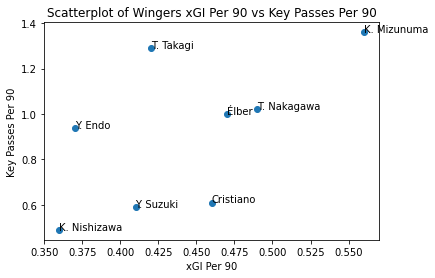

In [8]:
# Subsetting wingers with xGI greater than 0.35
wingers_scatter = wingers[wingers['xGI per 90'] > 0.35]

# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = wingers_scatter['xGI per 90'], y = wingers_scatter['Key passes per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Wingers xGI Per 90 vs Key Passes Per 90')
ax.set_xlabel('xGI Per 90')
ax.set_ylabel('Key Passes Per 90')

# Annotating points in axis with player names
for idx, row in wingers_scatter.iterrows():
    ax.annotate(row['Player'], (row['xGI per 90'], row['Key passes per 90']) )
plt.show()

<AxesSubplot:>

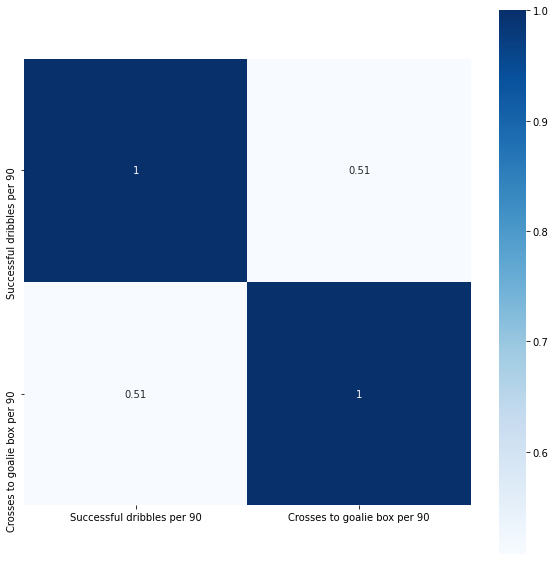

In [9]:
corr_dribbles_crosses = j1_players[['Successful dribbles per 90', 'Crosses to goalie box per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_dribbles_crosses.corr(), square=True, annot=True, cmap="Blues")

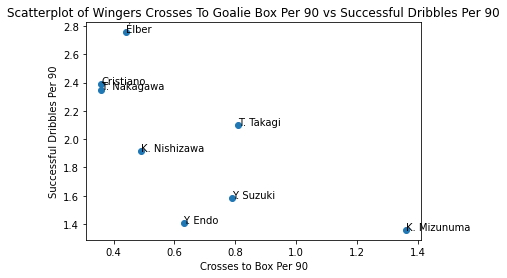

In [10]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = wingers_scatter['Crosses to goalie box per 90'], y = wingers_scatter['Successful dribbles per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of Wingers Crosses To Goalie Box Per 90 vs Successful Dribbles Per 90')
ax.set_xlabel('Crosses to Box Per 90')
ax.set_ylabel('Successful Dribbles Per 90')

# Annotating points in axis with player names
for idx, row in wingers_scatter.iterrows():
    ax.annotate(row['Player'], (row['Crosses to goalie box per 90'], row['Successful dribbles per 90']) )
plt.show()

### Identifying Attacking Midfielders

In [11]:
# Subsetting attacking mids
attacking_mids = j1_players[j1_players['Position'].str.contains(r'(?:\s|^)AMF(?:\s|$)')]
# Selecting relevant criteria
attacking_mids = attacking_mids[['Player', 'Team', 'Position', 'Age', 'Market value', 'Minutes played', 'Goals', 'Assists', 'xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90']].dropna()
# Sorting by key passes per 90
attacking_mids_key_passes = attacking_mids.sort_values(by='Key passes per 90', ascending=False).head(10)
attacking_mids_key_passes.style.background_gradient(subset=['xG per 90', 'xA per 90', 'xGI per 90', 'Key passes per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90'], cmap='Blues')

,Player,Team,Position,Age,Market value,Minutes played,Goals,Assists,xG per 90,xA per 90,xGI per 90,Key passes per 90,Progressive runs per 90,Acc. passes to final 3rd per 90
174,Y. Endo,Vegalta Sendai,"RW, RAMF, AMF",33,500000,575,1,3,0.050000,0.320000,0.370000,0.940000,1.100000,3.444375
8,Marcos Júnior,Yokohama F. Marinos,AMF,29,1900000,2275,8,4,0.330000,0.280000,0.610000,0.910000,0.750000,4.629810
111,Juan Alano,Kashima Antlers,"RW, RAMF, AMF",25,700000,1477,4,3,0.220000,0.220000,0.440000,0.850000,1.710000,2.500878
130,Y. Muto,Kashiwa Reysol,"CF, AMF",33,600000,1539,0,2,0.110000,0.120000,0.230000,0.530000,0.640000,2.517396
11,H. Kiyotake,Cerezo Osaka,"LW, CF, AMF",32,1600000,2576,2,3,0.130000,0.100000,0.230000,0.520000,1.430000,4.892679
145,T. Arano,Consadole Sapporo,"RCMF, CF, AMF",28,600000,1660,0,1,0.070000,0.100000,0.170000,0.430000,1.300000,4.774209
57,Y. Asano,Sanfrecce Hiroshima,"CF, RWF, AMF",25,900000,1955,5,0,0.230000,0.070000,0.300000,0.410000,1.430000,1.333908
5,Andrés Iniesta,Vissel Kobe,AMF,37,2000000,2042,7,5,0.240000,0.140000,0.380000,0.400000,1.540000,8.328024
146,Y. Komai,Consadole Sapporo,"RCMF, LCMF, AMF",29,600000,3437,1,3,0.050000,0.050000,0.100000,0.370000,1.130000,5.894160
155,N. Nomura,Oita Trinita,"RW, LW, AMF",30,550000,732,1,1,0.110000,0.190000,0.300000,0.370000,0.980000,2.338560


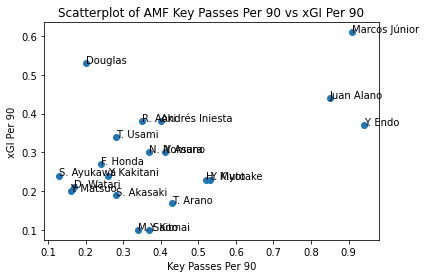

In [12]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = attacking_mids['Key passes per 90'], y = attacking_mids['xGI per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of AMF Key Passes Per 90 vs xGI Per 90')
ax.set_xlabel('Key Passes Per 90')
ax.set_ylabel('xGI Per 90')

# Annotating points in axis with player names
for idx, row in attacking_mids.iterrows():
    ax.annotate(row['Player'], (row['Key passes per 90'], row['xGI per 90']) )
plt.show()

<AxesSubplot:>

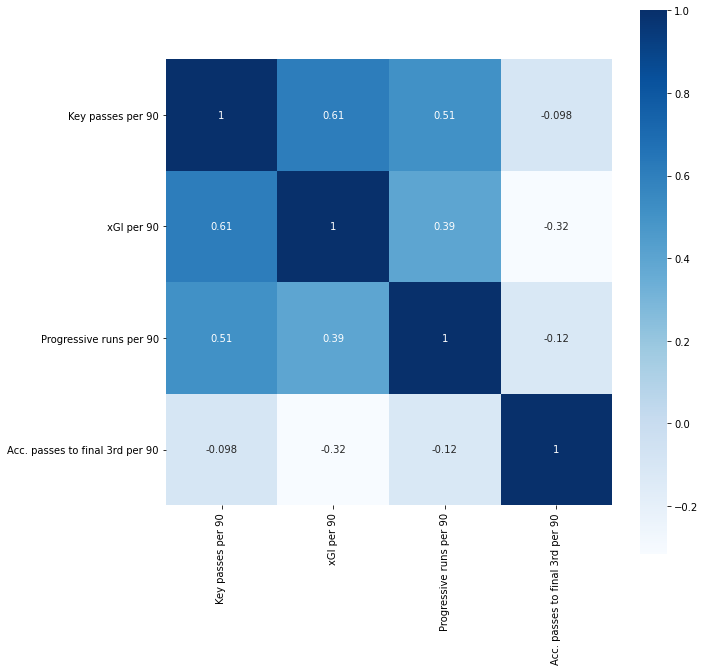

In [13]:
corr_plot = j1_players[['Key passes per 90', 'xGI per 90', 'Progressive runs per 90', 'Acc. passes to final 3rd per 90']].dropna()
pyplot.figure(figsize=(10, 10))
sns.heatmap(corr_plot.corr(), square=True, annot=True, cmap="Blues")

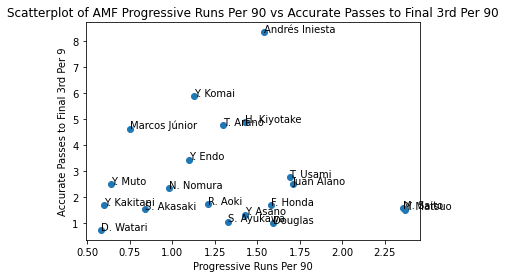

In [14]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = attacking_mids['Progressive runs per 90'], y = attacking_mids['Acc. passes to final 3rd per 90'])
# Setting axis title and labels
ax.set_title('Scatterplot of AMF Progressive Runs Per 90 vs Accurate Passes to Final 3rd Per 90')
ax.set_xlabel('Progressive Runs Per 90')
ax.set_ylabel('Accurate Passes to Final 3rd Per 9')

# Annotating points in axis with player names
for idx, row in attacking_mids.iterrows():
    ax.annotate(row['Player'], (row['Progressive runs per 90'], row['Acc. passes to final 3rd per 90']) )
plt.show()

# Identifying Undervalued Players using XGBoost Regressor with Bayesian Hyperparameter Optimisation

### Market Value Variable Exploration

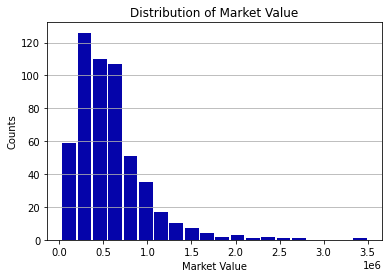

In [15]:
# Removing players with market value = 0
MV = j1_players[j1_players['Market value'] != 0]
# Plotting distribution of market value
MV['Market value'].plot.hist(grid=True, bins=20, rwidth=0.9, color='#0504aa')
# Setting plot titles
plt.title('Distribution of Market Value')
# Setting x-axis & y-axis titles
plt.xlabel('Market Value')
plt.ylabel('Counts')
# Adding horizontal grid lines to plot
plt.grid(axis='x', alpha=0.75)

In [16]:
# Average market value
np.mean(MV['Market value'])

577560.52141527

In [17]:
# Players with highest market value
MV.sort_values(by='Market value', ascending=False).head()

,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,Goals,...,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",xGI per 90,Successful dribbles per 90,Acc. passes to final 3rd per 90,Acc. passes to penalty area per 90,Acc. progressive passes per 90
380,H. Sakai,Urawa Reds,Urawa Reds,RB,31,3500000,2023-01-31 00:00:00,20,1757,2,...,0.00,0.00,0.0,0,0,0.19,0.462888,2.922948,1.125194,5.175050
0,J. Świerczok,Nagoya Grampus,Nagoya Grampus,CF,29,2700000,2024-01-31,14,834,7,...,0.32,66.67,0.0,0,0,0.42,1.834340,1.292835,0.969220,2.156608
1,Y. Muto,Vissel Kobe,Vissel Kobe,"CF, RAMF, RCMF",29,2500000,2023-01-31,18,1593,6,...,0.00,0.00,0.0,1,0,0.31,1.862469,1.133271,0.793305,1.921000
2,Lincoln,Vissel Kobe,Vissel Kobe,CF,21,2400000,2024-01-31,18,673,1,...,0.00,0.00,0.0,0,0,0.27,2.004492,2.269500,0.670000,2.138262
381,A. Scholz,Urawa Reds,Urawa Reds,LCB,29,2300000,2023-06-30 00:00:00,22,1948,1,...,0.00,0.00,0.0,1,100,0.05,0.553361,3.970043,0.091685,5.034688


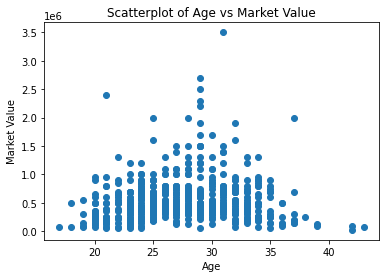

In [27]:
# Opening figure & axis
fig, ax = plt.subplots()
# Creating scatter plot
ax.scatter(x = MV['Age'], y = MV['Market value'])
# Setting axis title and labels
ax.set_title('Scatterplot of Age vs Market Value')
ax.set_xlabel('Age')
ax.set_ylabel('Market Value')

# # Annotating points in axis with player names
# for idx, row in wingers_scatter.iterrows():
#     ax.annotate(row['Player'], (row['Age'], row['Market value']) )
plt.show()

### XGBoost Regressor with Bayesian Hyperparameter Optimisation

In [18]:
def undervalued_players(pos):
    # Subsetting by position
    position = MV[MV['Position'].str.contains(pos)]
    # Splitting data into input and output columns
    X = position.filter(like='per 90', axis=1) # Subsetting variables to a per 90 basis
    y = position['Market value']
    # Converting the dataset into a Dmatrix that XGBoost supports
    data_dmatrix = xgb.DMatrix(data=X,label=y)

    # Splitting the data into training (80%) & test sets (20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Defining search space for XGBoost hyperparameters
    xgboost_params = {
        'learning_rate':[0.01,0.75, 'uniform'],
        'n_estimators':list(range(3,300,3)),
        'max_depth':list(range(1,50)),
        'reg_lambda':[1.0,30.0,'uniform'],
        'reg_alpha':[0.0,20.0,'uniform'],
        'min_child_weight': list(range(1,15)),
        'subsample': [0.0,1.0,'uniform'],
        'colsample_bytree': [0.0,1.0,'uniform'],
    }

    # Defining our model
    estimator = xgb.XGBRegressor()
    # K-fold Cross Validation
    cv = KFold(n_splits = 5, shuffle = False)
    # Number of Bayesian trial runs (more iterations = better model, longer runtime)
    n_iter = 100
    # Number of Bayesian trials to run simultaneously (fewer iterations = better model, longer runtime)
    n_points = 4
    # Bayesian Search
    search = BayesSearchCV(
        estimator = estimator,
        n_iter = n_iter,
        n_points = n_points,
        search_spaces = xgboost_params,
        n_jobs = -1,
        cv = cv)

    # Measuring runtime, starting here
    start_time = time()

    # Fitting Model
    search = search.fit(X_train, y_train)

    # Generating train predictions
    y_pred_train = search.predict(X_train)
    # Generating Test Predictions
    y_pred_test = search.predict(X_test)

    # Measuring runtime, ending here
    end_time = time()
    # Printing runtime
    print("{0:.2f} Minutes".format((end_time - start_time)/60))

    # Using these parameters in a model
    model = xgb.XGBRegressor().set_params(**dict(search.best_params_))

    # Fitting the model
    model.fit(X_train, y_train)
    # Predict the model
    pred = model.predict(X_test)
    # RMSE Computation
    rmse = np.sqrt(MSE(y_test, pred))
    print("RMSE : % f" %(rmse))

    ### Identifying the most undervalued player in that position
    # Finding the difference between the predicted and actual market values
    MV_diff = (y_test-y_pred_test).sort_values().head()
    # Converting to pandas dataframe
    MV_diff = pd.DataFrame(MV_diff)
    # Renaming market value column to 'Over/Undervaluation'
    MV_diff = MV_diff.rename({'Market value': 'Over/Undervaluation'}, axis=1)
    # Creating dataframe of player details
    player_details = j1_players[['Player', 'Team', 'Position', 'Age', 'Market value']]
    # Converting to pandas dataframe
    player_details = pd.DataFrame(player_details)
    # Appending player details to MV over/undervaluation
    undervalued = MV_diff.join(player_details)
    # Re-ordering columns
    cols = undervalued.columns.tolist()
    # Placing first column as last column
    cols = cols[1:] + cols[0:1]
    undervalued = undervalued[cols]
    # Output
    return undervalued

### Creating an Optimal Starting XI of Undervalued Players

In [19]:
undervalued_players(pos = 'CF')

2.25 Minutes
RMSE :  502354.274766


,Player,Team,Position,Age,Market value,Over/Undervaluation
273,F. Honda,Sagan Tosu,"CF, RW, AMF",20,300000,-398654.18750
337,S. Nakamura,Yokohama,"AMF, LCMF, CF",43,75000,-293017.03125
138,Y. Kamiya,Shimizu S-Pulse,"LW, CF, RW",24,600000,-234012.81250
118,M. Saito,Nagoya Grampus,"LW, CF, AMF",31,650000,-219570.75000
324,H. Jogo,Avispa Fukuoka,"CF, LW",35,150000,-218017.03125


In [21]:
undervalued_players(pos = r'(?:\s|^)LW|LWF|LAMF(?:\s|$)')

2.32 Minutes
RMSE :  340083.366834


,Player,Team,Position,Age,Market value,Over/Undervaluation
334,K. Fujimoto,Oita Trinita,"LB, LW, LWF",23,100000,-341947.65625
257,H. Yamada,Cerezo Osaka,"CF, RW, LW",22,350000,-324065.93750
547,K. Kurokawa,Gamba Osaka,"LB, LWB",24,250000,-182282.56250
278,Y. Iwasaki,Sagan Tosu,"CF, LWB",23,300000,-175935.40625
279,H. Tameda,Cerezo Osaka,"LAMF, LW",28,300000,-141947.65625


In [22]:
undervalued_players(pos = r'(?:\s|^)RW|RWF|RAMF(?:\s|$)')

2.29 Minutes
RMSE :  253457.992495


,Player,Team,Position,Age,Market value,Over/Undervaluation
265,J. Nishikawa,Sagan Tosu,"RW, CF",20,300000,-379743.9375
344,Y. Kitajima,Avispa Fukuoka,"LW, RCMF, RW",21,75000,-340353.1250
273,F. Honda,Sagan Tosu,"CF, RW, AMF",20,300000,-291595.2500
326,K. Konno,Tokyo,"RW, RWF, RAMF",24,150000,-265353.1250
315,E. Oti,Melaka United,"LW, RW, CF",25,175000,-240353.1250


In [23]:
undervalued_players(pos = r'(?:\s|^)AMF(?:\s|$)')

2.28 Minutes
RMSE :  594185.692442


,Player,Team,Position,Age,Market value,Over/Undervaluation
323,H. Yamami,Gamba Osaka,"CF, RW, AMF",22,150000,-343869.06250
155,N. Nomura,Oita Trinita,"RW, LW, AMF",30,550000,-87159.18750
111,Juan Alano,Kashima Antlers,"RW, RAMF, AMF",25,700000,138327.37500
94,K. Omori,Júbilo Iwata,"RW, LW, AMF",29,700000,206130.93750
90,D. Watari,Avispa Fukuoka,"CF, AMF",28,700000,271178.28125


In [24]:
undervalued_players(pos = r'(?:\s|^)LCMF|RCMF(?:\s|$)')

2.53 Minutes
RMSE :  509312.079471


,Player,Team,Position,Age,Market value,Over/Undervaluation
336,Y. Endō,Júbilo Iwata,"LCMF, RCMF",42,100000,-502999.87500
133,T. Seko,Kawasaki Frontale,"LCMF, RCMF",24,600000,-395115.93750
269,H. Miyuki,Omiya Ardija,"DMF, LCMF",28,300000,-315900.43750
169,Rhayner,Sanfrecce Hiroshima,"LCMF, RCMF",31,500000,-181147.37500
295,K. Haneda,Oita Trinita,RCMF,24,250000,-179843.03125


In [25]:
undervalued_players(pos = r'(?:\s|^)DMF|LDMF|RDMF(?:\s|$)')

2.46 Minutes
RMSE :  272938.872943


,Player,Team,Position,Age,Market value,Over/Undervaluation
285,S. Tomita,Vegalta Sendai,"RCMF, LCMF, RDMF",35,250000,-338383.4375
162,K. Iwao,Urawa Reds,"LCMF, LDMF, RDMF",33,550000,-306963.8750
234,K. Okuno,Gamba Osaka,"RCMF, LCMF, DMF",21,400000,-257321.5000
149,J. Fujita,Yokohama F. Marinos,"RCMF, LDMF, LCMF",20,600000,-177408.6875
261,R. Nakamura,Kashima Antlers,"DMF, RCMF",24,350000,-166955.7500


In [28]:
undervalued_players(pos = r'(?:\s|^)LB|LWB(?:\s|$)')

2.56 Minutes
RMSE :  191686.977128


,Player,Team,Position,Age,Market value,Over/Undervaluation
565,E. Takeda,Yokohama,"LB, LWB",33,175000,-340552.12500
575,K. Bangunagande,Tokyo,LB,20,125000,-311207.31250
292,S. Takahashi,V-Varen Nagasaki,"RB, LWB",31,250000,-279237.37500
528,R. Okui,V-Varen Nagasaki,"LB, RB",31,300000,-251360.18750
278,Y. Iwasaki,Sagan Tosu,"CF, LWB",23,300000,-151713.71875


In [29]:
undervalued_players(pos = r'(?:\s|^)RB|RWB(?:\s|$)')

2.25 Minutes
RMSE :  191574.899795


,Player,Team,Position,Age,Market value,Over/Undervaluation
577,Y. Sato,Gamba Osaka,"RCB, RB, LCB",23,125000,-396863.71875
558,K. Iwatake,Yokohama,"RCB, RB, LCB",25,200000,-201309.40625
536,K. Yanagisawa,Gamba Osaka,"RB, RWB",25,300000,-128084.34375
487,Y. Koide,Oita Trinita,"RCB, RB, RWB",27,400000,-125234.06250
292,S. Takahashi,V-Varen Nagasaki,"RB, LWB",31,250000,-93756.65625


In [30]:
undervalued_players(pos = r'(?:\s|^)CB|LCB|RCB(?:\s|$)')

2.34 Minutes
RMSE :  365224.808678


,Player,Team,Position,Age,Market value,Over/Undervaluation
576,H. Ishii,Tokushima Vortis,LCB,36,125000,-483884.5000
540,H. Takahashi,Yokohama,"CB, LCMF, RCMF",34,250000,-433202.8750
532,Y. Hakamata,Júbilo Iwata,"LCB, LB",25,300000,-360004.8125
229,L. Osaki,Vissel Kobe,"DMF, LDMF, RCB",30,400000,-336896.0625
584,M. Inoha,NaN,RCB,36,100000,-248569.5000


In [31]:
undervalued_players(pos = r'(?:\s|^)GK(?:\s|$)')

2.26 Minutes
RMSE :  226854.501393


,Player,Team,Position,Age,Market value,Over/Undervaluation
593,K. Tanno,Kawasaki Frontale,GK,35,50000,-409232.03125
566,T. Kodama,Tokyo,GK,34,175000,-353306.12500
562,T. Sugeno,Consadole Sapporo,GK,37,200000,-248443.15625
486,W. Popp,Machida Zelvia,GK,27,400000,-138704.56250
473,G. Hatano,Tokyo,GK,23,500000,-133718.75000
